# Value regression

In [73]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

df = sns.load_dataset('mpg').drop("name", axis=1)

df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,usa
1,15.0,8,350.0,165.0,3693,11.5,70,usa
2,18.0,8,318.0,150.0,3436,11.0,70,usa
3,16.0,8,304.0,150.0,3433,12.0,70,usa
4,17.0,8,302.0,140.0,3449,10.5,70,usa


In [74]:
df["origin"].value_counts()

origin
usa       249
japan      79
europe     70
Name: count, dtype: int64

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [76]:
df.query("horsepower.isna()")

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
32,25.0,4,98.0,NaN,2046,19.0,71,usa
126,21.0,6,200.0,NaN,2875,17.0,74,usa
330,40.9,4,85.0,NaN,1835,17.3,80,europe
336,23.6,4,140.0,NaN,2905,14.3,80,usa
354,34.5,4,100.0,NaN,2320,15.8,81,europe
374,23.0,4,151.0,NaN,3035,20.5,82,usa


In [77]:
df.dropna(inplace=True, axis=0)

<Axes: xlabel='model_year'>

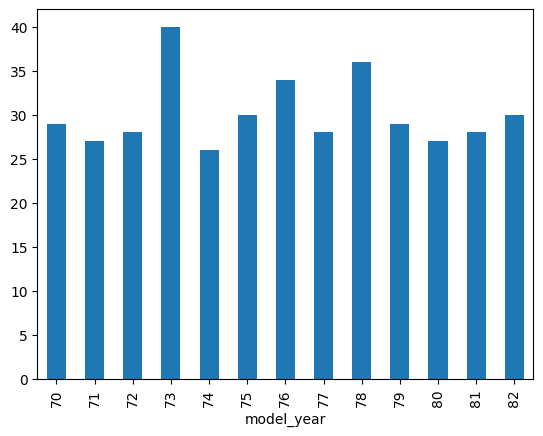

In [78]:
df["model_year"].value_counts().sort_index().plot(kind="bar")

In [79]:
bins = pd.IntervalIndex.from_tuples([(69, 73), (74, 77), (78, 82)])

df["model_year"] = pd.cut(df["model_year"], bins=bins)

df = pd.get_dummies(df, columns=["model_year", "origin"], drop_first=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,"model_year_(74, 77]","model_year_(78, 82]",origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,False,False,False,True
1,15.0,8,350.0,165.0,3693,11.5,False,False,False,True
2,18.0,8,318.0,150.0,3436,11.0,False,False,False,True
3,16.0,8,304.0,150.0,3433,12.0,False,False,False,True
4,17.0,8,302.0,140.0,3449,10.5,False,False,False,True


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df.drop("mpg", axis=1).values, df["mpg"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((274, 9), (118, 9))

In [81]:
scaled_X_train.max()

3.2869431314281545

In [82]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(scaled_X_train, y_train)

intercept, coef = model_lr.intercept_, model_lr.coef_
coef

array([-0.07963534,  0.71698622, -1.5802261 , -4.49219087, -0.08849455,
        0.36793355,  2.76523073,  0.02957218, -1.25074873])

In [83]:
import keras
from keras import layers
from keras.optimizers import SGD

inputs = keras.Input(shape=(X_train.shape[1],), name="Input layer")
outputs = layers.Dense(1, name="outputs")(inputs)
model_shallow = keras.Model(inputs=inputs, outputs=outputs)

model_shallow.compile(loss="mean_squared_error", optimizer=SGD(learning_rate=0.01))

model_shallow.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

In [84]:
model_shallow.fit(scaled_X_train, y_train, epochs=50, verbose=0,
                  validation_data=(scaled_X_test, y_test))

<Axes: xlabel='Epochs', ylabel='Loss'>

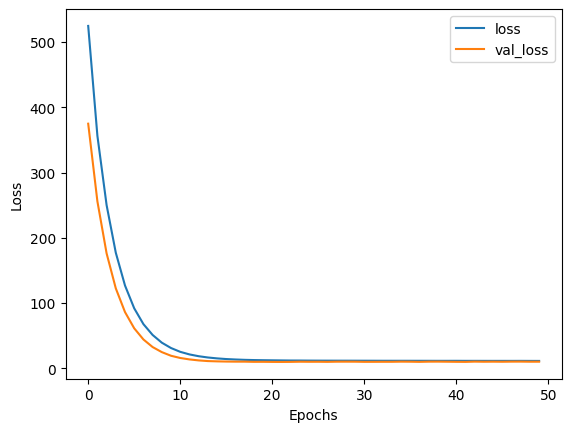

In [85]:
pd.DataFrame(model_shallow.history.history).plot(xlabel="Epochs", ylabel="Loss")

In [86]:
weights, bias = model_shallow.layers[1].get_weights()
weights, coef

(array([[-0.58183223],
        [-0.48382506],
        [-1.9822065 ],
        [-2.7276993 ],
        [-0.45486924],
        [ 0.2229805 ],
        [ 2.6198447 ],
        [ 0.22889547],
        [-0.9823367 ]], dtype=float32),
 array([-0.07963534,  0.71698622, -1.5802261 , -4.49219087, -0.08849455,
         0.36793355,  2.76523073,  0.02957218, -1.25074873]))

In [87]:
bias, intercept

(array([23.656033], dtype=float32), 23.637591240875913)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_regression(y_pred):
    mse = mean_squared_error(y_test, y_pred)
    return mean_absolute_error(y_test, y_pred), np.sqrt(mse)

y_pred_NN = model_shallow.predict(scaled_X_test)
y_pred_LR = model_lr.predict(scaled_X_test)

scores = {model: evaluate_regression(y_test, y_pred) for model, y_pred in zip(["NN", "LR"], [y_pred_NN, y_pred_LR])}

df_scores = pd.DataFrame(scores, index=["MAE", "MSE", "RMSE"])

df_scores["RMSE_prop"] = df_scores["RMSE"] / y_test.mean()

df_scores

InvalidArgumentError: Graph execution error:

Detected at node functional_5_1/outputs_1/Add defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\user\AppData\Local\Temp\ipykernel_17340\1652204953.py", line 7, in <module>

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 510, in predict

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 208, in one_step_on_data_distributed

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 198, in one_step_on_data

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 96, in predict_step

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py", line 584, in call

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py", line 146, in call

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\numpy.py", line 168, in add

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\sparse.py", line 493, in sparse_wrapper

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 38, in add

Matrix size-incompatible: In[0]: [32,30], In[1]: [9,1]
	 [[{{node functional_5_1/outputs_1/Add}}]] [Op:__inference_one_step_on_data_distributed_4099]

# Classification


In [90]:
from sklearn.datasets import load_breast_cancer

sns.set_style("white")

raw_data = load_breast_cancer()
X, y = raw_data.data, raw_data.target

np.isnan(X).any()

False

In [91]:
X.shape, y.shape

((569, 30), (569,))

In [92]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

scaled_X_train_val = scaler.fit_transform(X_train_val)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

scaled_X_train = scaler.fit_transform(X_train)

In [99]:
model = keras.Sequential([layers.InputLayer((X.shape[1],), name="Input"),
                          layers.Dense(30, name="Layer_1", activation="relu"),
                          layers.Dense(30, name="Layer_2", activation="relu"),
                          layers.Dense(1, name="Output", activation="sigmoid")],
                          name="Classifier")

model.compile(loss="binary_crossentropy", optimizer="adam")
model.summary()

Model: "Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Layer_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,891 (7.39 KB)

 Trainable params: 1,891 (7.39 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
model.fit(scaled_X_train_val, y_train_val, epochs=1000, validation_data=(scaled_X_val, y_val), verbose=0)

<Axes: xlabel='Epochs', ylabel='Cross-entropy_Loss'>

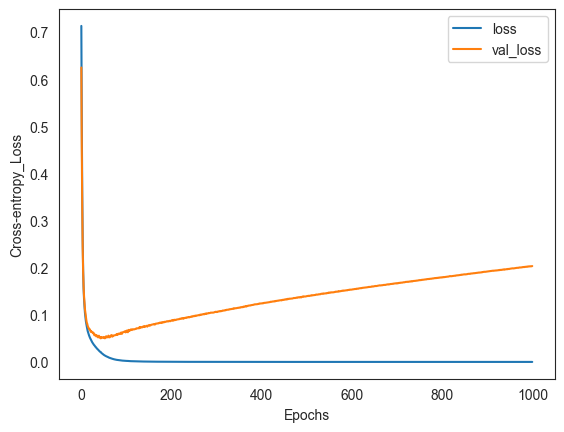

In [101]:
pd.DataFrame(model.history.history).plot(xlabel="Epochs", ylabel="Cross-entropy_Loss")

In [102]:
from keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=15)

model = keras.Sequential([layers.InputLayer((X.shape[1],), name="Input"),
                          layers.Dense(30, name="Layer_1", activation="relu"),
                          layers.Dense(30, name="Layer_2", activation="relu"),
                          layers.Dense(1, name="Output", activation="sigmoid")],
                          name="Classifier")

model.compile(loss="binary_crossentropy", optimizer="adam")

model.fit(scaled_X_train_val, y_train_val, epochs=1000, 
          validation_data=(scaled_X_val, y_val), callbacks=[early_stopper], verbose=1)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.7799 - val_loss: 0.5950
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5619 - val_loss: 0.4421
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4060 - val_loss: 0.3250
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3042 - val_loss: 0.2429
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2282 - val_loss: 0.1900
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1774 - val_loss: 0.1557
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1535 - val_loss: 0.1314
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1290 - val_loss: 0.1133
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1070 - val_loss: 0.1004
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0863 - val_loss: 0.0919
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0772 - val_loss: 0.0839
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/st

<Axes: xlabel='Epochs', ylabel='Cross-entropy Loss'>

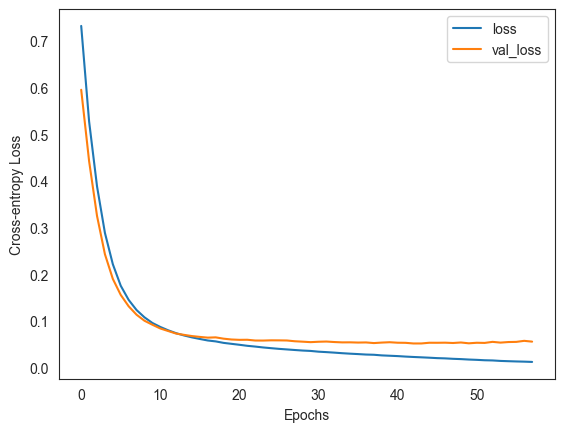

In [103]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot(xlabel="Epochs", ylabel="Cross-entropy Loss")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
[[0.947646  ]
 [0.00170239]
 [0.02633639]
 [0.9949063 ]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.96      1.00      0.98        54

    accuracy                           0.98        86
   macro avg       0.98      0.97      0.97        86
weighted avg       0.98      0.98      0.98        86



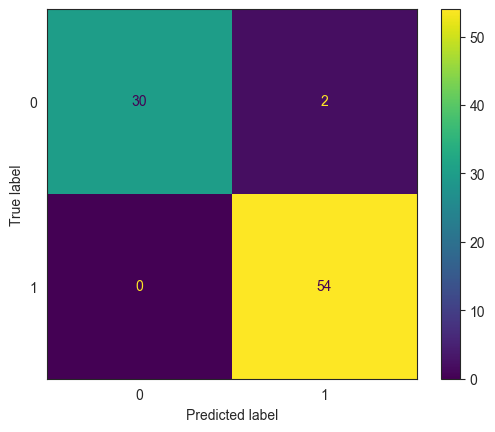

In [107]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

model = keras.Sequential([layers.InputLayer((X.shape[1],), name="Input"),
                          layers.Dense(30, name="Layer_1", activation="relu"),
                          layers.Dense(30, name="Layer_2", activation="relu"),
                          layers.Dense(1, name="Output", activation="sigmoid")],
                          name="Classifier")

model.compile(loss="binary_crossentropy", optimizer="adam")

#scaled_X_train.shape, y_train.shape

model.fit(scaled_X_train, y_train, epochs=len(df_loss), validation_data=[scaled_X_test, y_test], 
          callbacks=[early_stopper], verbose=0)

final_loss = pd.DataFrame(model.history.history)

y_pred = model.predict(scaled_X_test)
print(y_pred[:4])

y_pred = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_test, y_pred))